In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### helper functions for building cnn

def conv(x, W):
    """simple wrapper for tf.nn.conv2d"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool(x):
    """simple wrapper for tf.nn.max_pool with stride size 2"""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
  
def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
    return accuracy

#download mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/mnist', one_hot=True)

In [0]:
### cnn model class, used to store weights and compute intermediate network outputs

class Model:
  
  def __init__(self,_n1,_n2,_n3,_W_conv1,_b_conv1,_W_conv2,_b_conv2,_W_fc1,_b_fc1,_W_fc2,_b_fc2):
    self._n1 = _n1
    self._n2 = _n2
    self._n3 = _n3
    self._W_conv1 = _W_conv1
    self._W_conv2 = _W_conv2
    self._b_conv1 = _b_conv1
    self._b_conv2 = _b_conv2
    self._W_fc1 = _W_fc1
    self._W_fc2 = _W_fc2
    self._b_fc1 = _b_fc1
    self._b_fc2 = _b_fc2
  
  def get_logits(self,image):
    fc1 = self.get_layer_output(image,3,False)
    logits = tf.add(tf.matmul(fc1,self._W_fc2),self._b_fc2)
    probs = tf.nn.softmax(logits)
    return logits
  
  def get_layer_output(self,image,layer,pre_relu = False):  
    relu1_in = tf.add(conv(image,self._W_conv1),self._b_conv1)
    _h_conv1 = tf.nn.relu(relu1_in)
    _h_pool1 = maxpool(_h_conv1)
    
    relu2_in = tf.add(conv(_h_pool1,self._W_conv2),self._b_conv2)
    _h_conv2 = tf.nn.relu(relu2_in)
    _h_pool2 = maxpool(_h_conv2)
      
    h_pool2_flat = tf.reshape(_h_pool2, [-1, 7*7*self._n2])
    
    fc_relu_in = tf.add(tf.matmul(h_pool2_flat, self._W_fc1), self._b_fc1)
    _h_fc1 = tf.nn.relu(fc_relu_in)
    
    
    if layer == 1 and pre_relu == False:
      return _h_conv1
    if layer == 1 and pre_relu == True:
      return relu1_in
    if layer == 2 and pre_relu == False:
      return _h_conv2
    if layer == 2 and pre_relu == True:
      return relu2_in
    if layer == 3: 
      return _h_fc1
   
    return None
  
  def get_channel(self,image,layer,channel,pre_relu = False):
    layer_out = self.get_layer_output(image,layer,pre_relu)
    return layer_out[:,:,:,channel-1]
                              
  def get_channel_loss(self,image,layer,channel,pre_relu = False):
    channel_out = self.get_channel(image,layer,channel,pre_relu)
    return tf.reduce_mean(channel_out)
  
  def get_logit_loss(self,image,logit_ind):
    logits = self.get_logits(image)
    return logits[0,logit_ind]    
    
    

In [0]:
### training section for cnn

G = tf.Graph()

with G.as_default():

  x = tf.placeholder(tf.float32, [None, 784], name='x')
  y = tf.placeholder(tf.float32, [None, 10], name='y')
  pkeep = tf.placeholder(tf.float32, name='pkeep')

  n1 = 32
  n2 = 64
  n3 = 1024
  x_image = tf.reshape(x, [-1,28,28,1]) # batch, then width, height, channels
  # cnn layer 1
  W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 1, n1])
  b_conv1 = tf.get_variable('b_conv1', shape=[n1])
  h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
  # pool 1
  h_pool1 = maxpool(h_conv1)
  # cnn layer 2
  W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, n1, n2])
  b_conv2 = tf.get_variable('b_conv2', shape=[n2])
  h_conv2 = tf.nn.relu(tf.add(conv(h_pool1, W_conv2), b_conv2))
  # pool 2
  h_pool2 = maxpool(h_conv2)
  # fc layer to logits (7x7 since 2 rounds of maxpool)
  h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*n2])
  W_fc1 = tf.get_variable('W_fc1', shape=[7*7*n2, n3])
  b_fc1 = tf.get_variable('b_fc1', shape=[n3])
  h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_pool2_flat, W_fc1), b_fc1))
  # insert a dropout layer here.
  h_fc1_drop = tf.nn.dropout(h_fc1, pkeep)
  # one more fc layer
  # ... again, this is the logistic layer with softmax readout
  W_fc2 = tf.get_variable('W_fc2', shape=[n3,10])
  b_fc2 = tf.get_variable('b_fc2', shape=[10])
  logits = tf.add(tf.matmul(h_fc1_drop, W_fc2), b_fc2, name='logits_cnn2')

  saver = tf.train.Saver()

  sm_ce = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits, name='cross_ent_terms')
  cross_ent = tf.reduce_mean(sm_ce, name='cross_ent')
  loss = tf.reduce_mean(sm_ce, name='cross_ent')

  h_conv1_shape = tf.shape(h_conv1)
  h_conv2_shape = tf.shape(h_conv2)

  channel_1_shape = tf.shape(h_conv1[:,:,:,16])
  channel_2_shape = tf.shape(h_conv2[:,:,:,32])

  prediction = tf.argmax(logits, 1, name='pred_class')
  true_label = tf.argmax(y, 1, name='true_class')
  accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))

  opt = tf.train.AdamOptimizer(1e-4)
  train_step = opt.minimize(loss)

  batch_size = 100

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1001):
      batch = mnist.train.next_batch(batch_size)
      X_batch = batch[0]
      y_batch = batch[1]

      sess.run(train_step,feed_dict={x: X_batch, y: y_batch, pkeep:0.5})
      if i%100 == 0: 
        test_error,test_logits = sess.run((accuracy,logits), {x:mnist.test.images, y:mnist.test.labels, pkeep:1.0})
        print("\rAfter step {0:3d}, test accuracy {1:0.4f}".format(i, test_error), flush=True)
        #print(test_logits)

    save_path = saver.save(sess, "/tmp/model.ckpt")

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


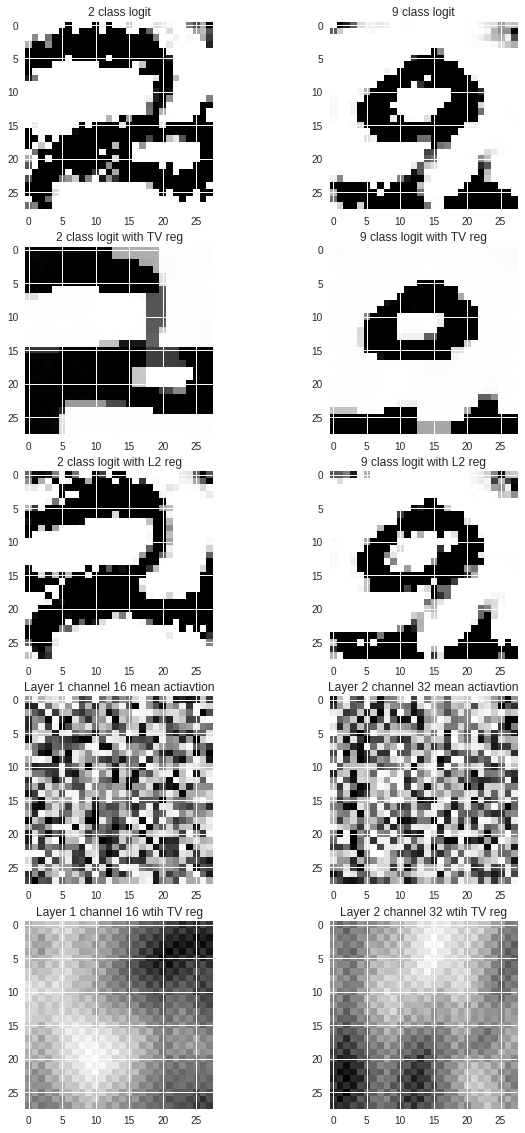

In [0]:
### feature visualization and plot outupt

with G.as_default():
  
  cnn_model = Model(n1,n2,n3,W_conv1,b_conv1,W_conv2,b_conv2,W_fc1,b_fc1,W_fc2,b_fc2)
  rand = tf.Variable(tf.random.uniform([28,28],minval = 0, maxval = 1,dtype = tf.float32))
  rand_image = tf.reshape(rand,[-1,28,28,1])

  log_ind1 = 2
  log_ind2 = 9

  channel_ind1 = 16
  channel_ind2 = 32
  layer1 = 1
  layer2 = 2
  
  log_ind1_loss = cnn_model.get_logit_loss(rand_image,log_ind1)
  log_ind2_loss = cnn_model.get_logit_loss(rand_image,log_ind2)

  log_ind1_loss_tv = log_ind1_loss - 0.05*tf.image.total_variation(rand_image)
  log_ind2_loss_tv = log_ind2_loss - 0.05*tf.image.total_variation(rand_image)

  log_ind1_loss_norm = log_ind1_loss - 0.05*tf.norm(rand_image)
  log_ind2_loss_norm = log_ind2_loss - 0.05*tf.norm(rand_image)

  channel_ind1_loss = cnn_model.get_channel_loss(rand_image,layer1,channel_ind1,False)
  channel_ind2_loss = cnn_model.get_channel_loss(rand_image,layer2,channel_ind2,False)

  channel_ind1_loss_tv = channel_ind1_loss - 0.05*tf.image.total_variation(rand_image)
  channel_ind2_loss_tv = channel_ind2_loss - 0.05*tf.image.total_variation(rand_image)

  opt = tf.train.GradientDescentOptimizer(0.05)

  ts_log_ind1_loss = opt.minimize(-log_ind1_loss,var_list = [rand])
  ts_log_ind2_loss = opt.minimize(-log_ind2_loss,var_list = [rand])
  ts_log_ind1_loss_tv = opt.minimize(-log_ind1_loss_tv, var_list = [rand])
  ts_log_ind2_loss_tv = opt.minimize(-log_ind2_loss_tv,var_list = [rand])
  ts_log_ind1_loss_norm = opt.minimize(-log_ind1_loss_norm,var_list = [rand])
  ts_log_ind2_loss_norm = opt.minimize(-log_ind2_loss_norm, var_list = [rand])
  ts_channel_ind1_loss = opt.minimize(-channel_ind1_loss, var_list = [rand])
  ts_channel_ind2_loss = opt.minimize(-channel_ind2_loss, var_list = [rand])
  ts_channel_ind1_loss_tv = opt.minimize(-channel_ind1_loss_tv, var_list = [rand])
  ts_channel_ind2_loss_tv = opt.minimize(-channel_ind2_loss_tv, var_list = [rand])

  #This implementation of projected gradient descent is taken from
  #https://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/
  proj = tf.clip_by_value(rand,0,1)
  with tf.control_dependencies([proj]):
    proj_step = tf.assign(rand,proj)

  rand_image_plt = tf.reshape(rand_image,[28,28])

  with tf.Session() as sess:
    saver.restore(sess, "/tmp/model.ckpt")
    
    plt.figure(figsize=(10,20))
    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind1_loss)
      sess.run(proj_step)
   
    ax = plt.subplot(5,2,1)
    ax.set_title('%g class logit'%(log_ind1))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind2_loss)
      sess.run(proj_step)

    ax = plt.subplot(5,2,2)
    ax.set_title('%g class logit'%(log_ind2))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind1_loss_tv)
      sess.run(proj_step)

    ax = plt.subplot(5,2,3)
    ax.set_title('%g class logit with TV reg'%(log_ind1))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind2_loss_tv)
      sess.run(proj_step)

    ax = plt.subplot(5,2,4)
    ax.set_title('%g class logit with TV reg'%(log_ind2))
    plt.imshow(rand_image_plt.eval())


    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind1_loss_norm)
      sess.run(proj_step)

    ax = plt.subplot(5,2,5)
    ax.set_title('%g class logit with L2 reg'%(log_ind1))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_log_ind2_loss_norm)
      sess.run(proj_step)

    ax = plt.subplot(5,2,6)
    ax.set_title('%g class logit with L2 reg'%(log_ind2))
    plt.imshow(rand_image_plt.eval())


    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_channel_ind1_loss)
      sess.run(proj_step)
 
    ax = plt.subplot(5,2,7)
    ax.set_title('Layer %g channel %g mean actiavtion'%(layer1,channel_ind1))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_channel_ind2_loss)
      sess.run(proj_step)

    ax = plt.subplot(5,2,8)
    ax.set_title('Layer %g channel %g mean actiavtion'%(layer2,channel_ind2))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_channel_ind1_loss_tv)
      sess.run(proj_step)

    ax = plt.subplot(5,2,9)
    ax.set_title('Layer %g channel %g wtih TV reg'%(layer1,channel_ind1))
    plt.imshow(rand_image_plt.eval())

    sess.run(tf.variables_initializer([rand]))
    for i in range(1500):
      sess.run(ts_channel_ind2_loss_tv)
      sess.run(proj_step)

    ax = plt.subplot(5,2,10)
    ax.set_title('Layer %g channel %g wtih TV reg'%(layer2,channel_ind2))
    plt.imshow(rand_image_plt.eval())
    
   